In [1]:
import os
import tensorflow as tf

# Set the GPU device ID you want to use (0, 1, 2, etc.)
gpu_device_id = "2" # Change this to the desired GPU device ID

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_device_id

# Check if TensorFlow sees the selected GPU
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Restrict TensorFlow to only use the selected GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Set memory growth to True to allow dynamic memory allocation
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Using GPU device", gpu_device_id)
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU devices found")

No GPU devices found


# Load the image and spectra data  

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import Dropout
import math as m
from tensorflow import keras
import numpy as np
image_data = np.loadtxt('/home/nano_photonics/rahul/images_2lakh.txt')
spectra_data = np.loadtxt('/home/nano_photonics/rahul/spectra2_lakh.txt')
label_data = np.loadtxt('/home/nano_photonics/rahul/label2lakh.txt')

spectra_data = np.reshape(spectra_data, (200000, 60, 4, 1))
image_data = np.reshape(image_data, (200000, 64, 64, 1))
# Split Data into Train and Test Sets
from sklearn.model_selection import train_test_split
x_train_images, x_val_images, x_train_spectra, x_val_spectra, y_train, y_val = train_test_split(image_data, spectra_data, label_data, test_size=0.3, random_state=42)
# x_train_images, x_test_images, x_train_spectra, x_test_spectra, y_train, y_test = train_test_split(x_train_images, x_train_spectra, y_train, test_size=0.2, random_state=42)
# print(x_train_images.shape, x_test_images.shape, x_val_images.shape, x_train_spectra.shape, x_test_spectra.shape, x_val_spectra.shape, y_train.shape, y_test.shape, y_val.shape)
print(x_train_images.shape, x_val_images.shape, x_train_spectra.shape, x_val_spectra.shape, y_train.shape, y_val.shape)

(140000, 64, 64, 1) (60000, 64, 64, 1) (140000, 60, 4, 1) (60000, 60, 4, 1) (140000,) (60000,)


# Define the necessary losses and the dual variational autoencoder concept

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, Conv2DTranspose, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.models import Model

# Encoder for shapes data
class ShapeSampling(layers.Layer):
    def call(self, inputs):
        z_mean_shape, z_log_var_shape = inputs
        batch = tf.shape(z_mean_shape)[0]
        dim = tf.shape(z_mean_shape)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean_shape + tf.exp(0.5 * z_log_var_shape) * epsilon

# Encoder for spectra data
class SpectrumSampling(layers.Layer):
    def call(self, inputs):
        z_mean_spectrum, z_log_var_spectrum = inputs
        batch = tf.shape(z_mean_spectrum)[0]
        dim = tf.shape(z_mean_spectrum)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean_spectrum + tf.exp(0.5 * z_log_var_spectrum) * epsilon

# Define the MMD loss function
def maximum_mean_discrepancy(z_mean_spectrum, z_log_var_spectrum):
    # Compute the mean and variance of the latent space distribution
    latent_mean_spectrum = tf.reduce_mean(z_mean_spectrum, axis=0)
    latent_var_spectrum = tf.reduce_mean(tf.exp(z_log_var_spectrum), axis=0)

    # Define a target distribution (e.g., Gaussian)
    target_mean_spectrum = tf.zeros(latent_dim)
    target_var_spectrum = tf.ones(latent_dim)

    # Compute the MMD loss
    mmd_loss = tf.reduce_sum(tf.square(latent_mean_spectrum - target_mean_spectrum) + target_var_spectrum - latent_var_spectrum)


    return mmd_loss
# Define custom regularization functions
def sparsity_regularizer(z_spectrum):
    return tf.reduce_sum(tf.abs(z_spectrum))



# Define custom disentanglement regularization (modify this based on your requirements)
def custom_disentanglement_regularizer(z_spectrum):
    # Modify this function to specify your custom disentanglement regularization logic
    return tf.reduce_sum(tf.square(z_spectrum))  # Example regularization (modify as needed)
mmd_scale_factor = 0.00001  # Adjust the MMD scale factor as needed
sparsity_coefficient = 0.00001
disentanglement_coefficient = 0.0001  # Adjust the disentanglement coefficient as needed
# Create a combined L1 and L2 regularizer
combined_regularizer = tf.keras.regularizers.l1_l2(l1=0.00001, l2=0.00000000001)

latent_dim = 8

def residual_block(x, filters, kernel_size=3):
    x_skip = x
    x = layers.Conv2D(filters, kernel_size, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = Dropout(0.15)(x)
    x = layers.Conv2D(filters, kernel_size, activation="relu", padding="same")(x)

    # Ensure that x_skip has the same number of channels as x
    x_skip = layers.Conv2D(filters, kernel_size=1, activation="relu", padding="same")(x_skip)

    x = Add()([x, x_skip])
    x = layers.Activation("relu")(x)
    return x

# Encoder for shapes data
shape_encoder_inputs = tf.keras.Input(shape=(64, 64, 1))
x_shape = layers.Conv2D(16, (2, 2), activation="relu", strides=2, kernel_regularizer=l1_l2(l1=0.0000001, l2=0.000001))(shape_encoder_inputs)
x_shape = layers.BatchNormalization()(x_shape)
x_shape = layers.Conv2D(32, (2, 2), activation="relu", strides=2, kernel_regularizer=l1_l2(l1=0.0000001, l2=0.0000001))(x_shape)
x_shape = residual_block(x_shape, 16)
x_shape = layers.Conv2D(64, (10, 10), activation="relu", strides=2, kernel_regularizer=l1_l2(l1=0.0000001, l2=0.0000001))(x_shape)
x_shape = layers.Flatten()(x_shape)
x_shape = layers.Dense(32, activation="relu")(x_shape)
z_mean_shape = layers.Dense(latent_dim, name="z_mean_shape")(x_shape)
z_log_var_shape = layers.Dense(latent_dim, name="z_log_var_shape")(x_shape)
z_shape = ShapeSampling()([z_mean_shape, z_log_var_shape])
shape_encoder = tf.keras.Model(shape_encoder_inputs, [z_mean_shape, z_log_var_shape, z_shape], name="shape_encoder")
shape_encoder.summary()

# Encoder for spectra data
spectrum_encoder_inputs = tf.keras.Input(shape=(60, 4, 1))
x_spectrum = layers.Conv2D(16, (53, 3), activation="tanh",kernel_initializer=GlorotUniform(), kernel_regularizer=l1_l2(l1=0.000000001, l2=0.000000001))(spectrum_encoder_inputs)
x_spectrum = Dropout(0.35)(x_spectrum)
x_spectrum = layers.Conv2D(32, (5, 2), activation="tanh",kernel_initializer=GlorotUniform(), kernel_regularizer=l1_l2(l1=0.000000001, l2=0.000000001))(x_spectrum)

x_spectrum = layers.Conv2D(64, (4, 1), activation="tanh",kernel_initializer=GlorotUniform(), kernel_regularizer=l1_l2(l1=0.000000001, l2=0.000000001))(x_spectrum)
x_spectrum = Dropout(0.26)(x_spectrum)
x_spectrum = layers.Flatten()(x_spectrum)
x_spectrum = layers.Dense(32, activation="tanh")(x_spectrum)
z_mean_spectrum = layers.Dense(latent_dim, name="z_mean_spectrum")(x_spectrum)
z_log_var_spectrum = layers.Dense(latent_dim, name="z_log_var_spectrum")(x_spectrum)
z_spectrum = SpectrumSampling()([z_mean_spectrum, z_log_var_spectrum])
spectrum_encoder = tf.keras.Model(spectrum_encoder_inputs, [z_mean_spectrum, z_log_var_spectrum, z_spectrum], name="spectrum_encoder")
spectrum_encoder.summary()
#Decoder for shape data
latent_inputs_shape = tf.keras.Input(shape=(latent_dim,))
x_shape = layers.Dense(32, activation="relu", kernel_regularizer=l1_l2(l1=0.00001, l2=0.0000001))(latent_inputs_shape)
x_shape = layers.Reshape((1, 1, 32))(x_shape)
x_shape = layers.Conv2DTranspose(64, (4, 4), activation="relu", strides=2, kernel_regularizer=l1_l2(l1=0.0000001, l2=0.00000001))(x_shape)
x_shape = layers.Conv2DTranspose(64, (10, 10), activation="relu", strides=2, kernel_regularizer=l1_l2(l1=0.0000001, l2=0.0000001))(x_shape)
x_shape = Dropout(0.2)(x_shape)
x_shape = layers.Conv2DTranspose(32, (2, 2), activation="relu", strides=2, kernel_regularizer=l1_l2(l1=0.0000001, l2=0.00001))(x_shape)
x_shape = layers.Conv2DTranspose(16, (2, 2), activation="relu", strides=2, kernel_regularizer=l1_l2(l1=0.000001, l2=0.0000001))(x_shape)
decoder_outputs_shape = layers.Conv2DTranspose(1, (1, 1), activation="sigmoid")(x_shape)
decoder_shape = tf.keras.Model(latent_inputs_shape, decoder_outputs_shape, name="decoder")
decoder_shape.summary()

#Decoder for spectrum data
latent_inputs_spectrum = tf.keras.Input(shape=(latent_dim,))
x_spectrum = layers.Dense(32, activation="tanh")(latent_inputs_spectrum)
x_spectrum = layers.Reshape((1, 1, 32))(x_spectrum)
x_spectrum = layers.BatchNormalization()(x_spectrum)
x_spectrum = layers.Conv2DTranspose(64, (4, 1), activation="tanh", kernel_initializer=GlorotUniform(), kernel_regularizer=l1_l2(l1=0.00001, l2=0.00001))(x_spectrum)

x_spectrum = Dropout(0.35)(x_spectrum)
x_spectrum = layers.Conv2DTranspose(32, (5, 2), activation="tanh",kernel_initializer=GlorotUniform(), kernel_regularizer=l1_l2(l1=0.00001, l2=0.00000001))(x_spectrum)
x_spectrum = layers.Conv2DTranspose(16, (53, 3), activation="tanh", kernel_regularizer=combined_regularizer)(x_spectrum)
x_spectrum = Dropout(0.3)(x_spectrum)
decoder_outputs_spectrum = layers.Conv2DTranspose(1, (1, 1), activation="sigmoid")(x_spectrum)

decoder_spectrum = tf.keras.Model(latent_inputs_spectrum, decoder_outputs_spectrum, name="decoder")
decoder_spectrum.summary()



Model: "shape_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   2080        batch_normalization[0][0]        
______________________________________________________________________________________

2024-04-14 22:42:20.640649: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 22:42:20.641534: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


Model: "spectrum_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 4, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 8, 2, 16)     2560        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 8, 2, 16)     0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 4, 1, 32)     5152        dropout_1[0][0]                  
___________________________________________________________________________________

# Define the all associated loss weight parameter

In [ ]:
kl_loss_shape_weight = 1e-5
kl_loss_spectrum_weight = 1e-6
mmd_loss_weight = 1e-6
sparsity_loss_weight = 1e-6
disentanglement_loss_weight = 1e-6

# Apply the coupled conditional variational autoencoder to define the training and testing step

In [ ]:

class CCVAE(tf.keras.Model):
    def __init__(self, shape_encoder, spectrum_encoder, decoder_shape, decoder_spectrum, temperature=1.0, **kwargs):
        super().__init__(**kwargs)
        self.shape_encoder = shape_encoder
        self.decoder_shape = decoder_shape
        self.spectrum_encoder = spectrum_encoder
        self.decoder_spectrum = decoder_spectrum
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_shape_tracker = keras.metrics.Mean(name="reconstruction_loss_shape")
        self.kl_loss_shape_tracker = keras.metrics.Mean(name="kl_loss_shape")
        self.reconstruction_loss_spectrum_tracker = keras.metrics.Mean(name="reconstruction_loss_spectrum")
        self.kl_loss_spectrum_tracker = keras.metrics.Mean(name="kl_loss_spectrum")
        self.mmd_loss_tracker = tf.keras.metrics.Mean(name="mmd_loss")
        self.sparsity_loss_tracker = tf.keras.metrics.Mean(name="sparsity_loss")
        self.disentanglement_loss_tracker = tf.keras.metrics.Mean(name="disentanglement_loss")
        self.cross_reconstruction_loss_shape_to_spectrum_tracker = keras.metrics.Mean(name="cross_reconstruction_loss_shape_to_spectrum")
        self.cross_reconstruction_loss_spectrum_to_shape_tracker = keras.metrics.Mean(name="cross_reconstruction_loss_spectrum_to_shape")

    def call(self, inputs):
        z_mean_shape, z_log_var_shape, z_shape = self.shape_encoder(inputs[0])
        z_mean_spectrum, z_log_var_spectrum, z_spectrum = self.spectrum_encoder(inputs[1])

        return self.decoder_shape(z_shape), self.decoder_spectrum(z_spectrum), z_mean_shape, z_log_var_shape, z_mean_spectrum, z_log_var_spectrum

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_shape_tracker,
            self.kl_loss_shape_tracker,
            self.reconstruction_loss_spectrum_tracker,
            self.kl_loss_spectrum_tracker,
            self.mmd_loss_tracker,
            self.sparsity_loss_tracker,
            self.disentanglement_loss_tracker,
            self.cross_reconstruction_loss_shape_to_spectrum_tracker,
            self.cross_reconstruction_loss_spectrum_to_shape_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean_shape, z_log_var_shape, z_shape = self.shape_encoder(data[0])
            z_mean_spectrum, z_log_var_spectrum, z_spectrum = self.spectrum_encoder(data[1])

            # Reconstruction losses
            reconstruction_loss_shape = tf.reduce_mean(
                tf.reduce_sum(keras.losses.mean_absolute_error(data[0], self.decoder_shape(z_shape)))
            )
            reconstruction_loss_spectrum = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.mean_absolute_error(data[1], self.decoder_spectrum(z_spectrum)))
            )
            cross_reconstruction_loss_shape_to_spectrum = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.mean_absolute_error(data[1], self.decoder_spectrum(z_shape)))
            )
            cross_reconstruction_loss_spectrum_to_shape = tf.reduce_mean(
                tf.reduce_sum(keras.losses.mean_absolute_error(data[0], self.decoder_shape(z_spectrum)))
            )

            # KL Divergence losses
            kl_loss_shape = -0.5 * (1 + z_log_var_shape - tf.square(z_mean_shape) - tf.exp(z_log_var_shape))
            kl_loss_spectrum = -0.5 * (1 + z_log_var_spectrum - tf.square(z_mean_spectrum) - tf.exp(z_log_var_spectrum))
            kl_loss_shape = tf.reduce_mean(tf.reduce_sum(kl_loss_shape, axis=1))
            kl_loss_spectrum = tf.reduce_mean(tf.reduce_sum(kl_loss_spectrum, axis=1))

            # MMD loss
            mmd_loss = maximum_mean_discrepancy(z_mean_spectrum, z_log_var_spectrum)
            mmd_loss *= mmd_scale_factor  # Adjust the scale factor as needed

            # Additional regularizers
            sparsity_loss = sparsity_regularizer(z_spectrum)
            disentanglement_loss = custom_disentanglement_regularizer(z_spectrum)

            # Total loss
            total_loss = (
                reconstruction_loss_shape + reconstruction_loss_spectrum +
                kl_loss_shape_weight * kl_loss_shape + kl_loss_spectrum_weight * kl_loss_spectrum +
                mmd_loss_weight * mmd_loss + sparsity_loss_weight * sparsity_loss +
                disentanglement_loss_weight * disentanglement_loss +
                cross_reconstruction_loss_shape_to_spectrum + cross_reconstruction_loss_spectrum_to_shape
            )

        # Update the model weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_shape_tracker.update_state(reconstruction_loss_shape)
        self.kl_loss_shape_tracker.update_state(kl_loss_shape)
        self.reconstruction_loss_spectrum_tracker.update_state(reconstruction_loss_spectrum)
        self.kl_loss_spectrum_tracker.update_state(kl_loss_spectrum)
        self.mmd_loss_tracker.update_state(mmd_loss)
        self.sparsity_loss_tracker.update_state(sparsity_loss)
        self.disentanglement_loss_tracker.update_state(disentanglement_loss)
        self.cross_reconstruction_loss_shape_to_spectrum_tracker.update_state(cross_reconstruction_loss_shape_to_spectrum)
        self.cross_reconstruction_loss_spectrum_to_shape_tracker.update_state(cross_reconstruction_loss_spectrum_to_shape)

        return {
            "loss": total_loss,
            "reconstruction_loss_shape": reconstruction_loss_shape,
            "reconstruction_loss_spectrum": reconstruction_loss_spectrum,
            "kl_loss_shape": kl_loss_shape,
            "kl_loss_spectrum": kl_loss_spectrum,
            "mmd_loss": mmd_loss,
            "sparsity_loss": sparsity_loss,
            "disentanglement_loss": disentanglement_loss,
            "cross_reconstruction_loss_shape_to_spectrum": cross_reconstruction_loss_shape_to_spectrum,
            "cross_reconstruction_loss_spectrum_to_shape": cross_reconstruction_loss_spectrum_to_shape,
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean_shape, z_log_var_shape, z_shape = self.shape_encoder(data[0])
        z_mean_spectrum, z_log_var_spectrum, z_spectrum = self.spectrum_encoder(data[1])

        # Reconstruction losses
        reconstruction_loss_shape = tf.reduce_mean(
            tf.reduce_sum(keras.losses.mean_squared_error(data[0], self.decoder_shape(z_shape)))
        )
        reconstruction_loss_spectrum = tf.reduce_mean(
            tf.reduce_sum(tf.keras.losses.mean_absolute_error(data[1], self.decoder_spectrum(z_spectrum)))
        )
        cross_reconstruction_loss_shape_to_spectrum = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.mean_absolute_error(data[1], self.decoder_spectrum(z_shape)))
        )
        cross_reconstruction_loss_spectrum_to_shape = tf.reduce_mean(
                tf.reduce_sum(keras.losses.mean_squared_error(data[0], self.decoder_shape(z_spectrum)))
        )

        # KL Divergence losses
        kl_loss_shape = -0.5 * (1 + z_log_var_shape - tf.square(z_mean_shape) - tf.exp(z_log_var_shape))
        kl_loss_spectrum = -0.5 * (1 + z_log_var_spectrum - tf.square(z_mean_spectrum) - tf.exp(z_log_var_spectrum))
        kl_loss_shape = tf.reduce_mean(tf.reduce_sum(kl_loss_shape, axis=1))
        kl_loss_spectrum = tf.reduce_mean(tf.reduce_sum(kl_loss_spectrum, axis=1))

        # MMD loss
        mmd_loss = maximum_mean_discrepancy(z_mean_spectrum, z_log_var_spectrum)
        mmd_loss *= mmd_scale_factor  # Adjust the scale factor as needed

        # Additional regularizers
        sparsity_loss = sparsity_regularizer(z_spectrum)
        disentanglement_loss = custom_disentanglement_regularizer(z_spectrum)

        # Total loss
        total_loss = (
            reconstruction_loss_shape + reconstruction_loss_spectrum +
            kl_loss_shape_weight * kl_loss_shape + kl_loss_spectrum_weight * kl_loss_spectrum +
            mmd_loss_weight * mmd_loss + sparsity_loss_weight * sparsity_loss +
            disentanglement_loss_weight * disentanglement_loss+ cross_reconstruction_loss_shape_to_spectrum+cross_reconstruction_loss_spectrum_to_shape
        )

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_shape_tracker.update_state(reconstruction_loss_shape)
        self.kl_loss_shape_tracker.update_state(kl_loss_shape)
        self.reconstruction_loss_spectrum_tracker.update_state(reconstruction_loss_spectrum)
        self.kl_loss_spectrum_tracker.update_state(kl_loss_spectrum)
        self.mmd_loss_tracker.update_state(mmd_loss)
        self.sparsity_loss_tracker.update_state(sparsity_loss)
        self.disentanglement_loss_tracker.update_state(disentanglement_loss)
        self.cross_reconstruction_loss_shape_to_spectrum_tracker.update_state(cross_reconstruction_loss_shape_to_spectrum)
        self.cross_reconstruction_loss_spectrum_to_shape_tracker.update_state(cross_reconstruction_loss_spectrum_to_shape)

        return {
            "loss": total_loss,
            "reconstruction_loss_shape": reconstruction_loss_shape,
            "reconstruction_loss_spectrum": reconstruction_loss_spectrum,
            "kl_loss_shape": kl_loss_shape,
            "kl_loss_spectrum": kl_loss_spectrum,
            "mmd_loss": mmd_loss,
            "sparsity_loss": sparsity_loss,
            "disentanglement_loss": disentanglement_loss,
            "cross_reconstruction_loss_shape_to_spectrum": cross_reconstruction_loss_shape_to_spectrum,
            "cross_reconstruction_loss_spectrum_to_shape": cross_reconstruction_loss_spectrum_to_shape,
        }




In [ ]:
ccvae = CCVAE(shape_encoder, spectrum_encoder, decoder_shape, decoder_spectrum)

# Load the save weights of the model

In [ ]:
ccvae.load_weights("/home/nano_photonics/rahul/Save/linking_vae_3(4)/")

# Plot the reconstruction image and reconstruction spectra

2024-04-14 22:42:21.576296: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-04-14 22:42:21.576655: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3299990000 Hz


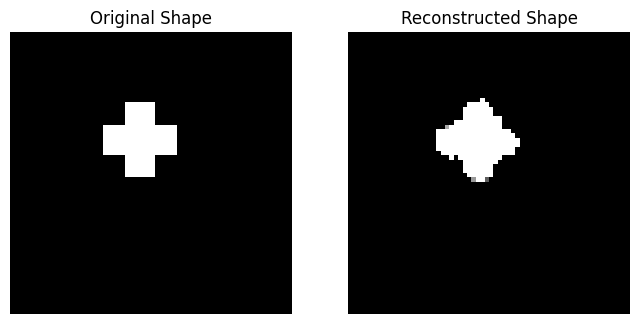

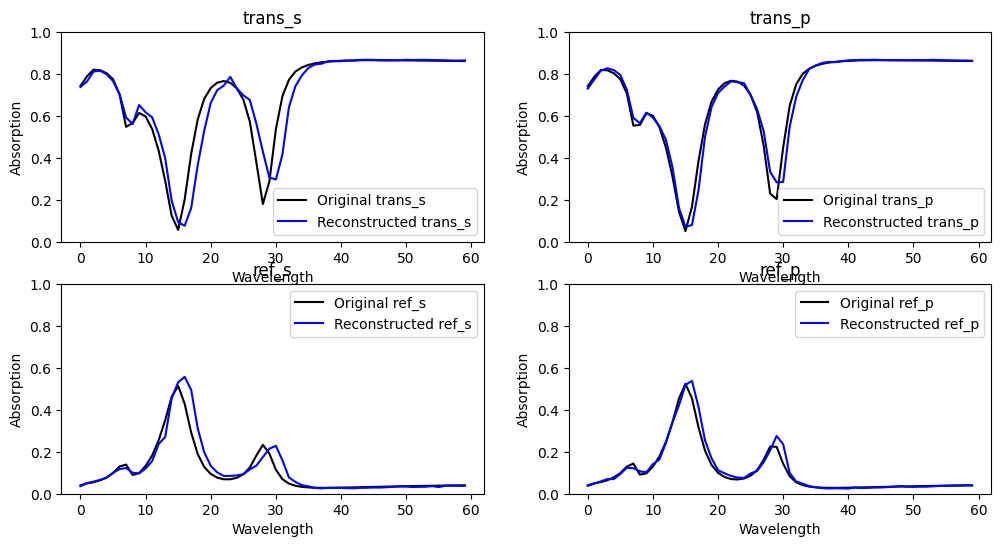

Current Index: 89000


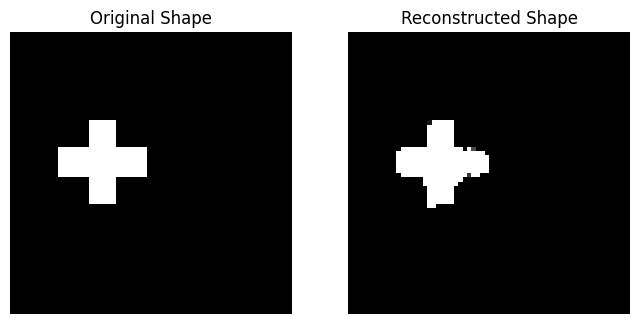

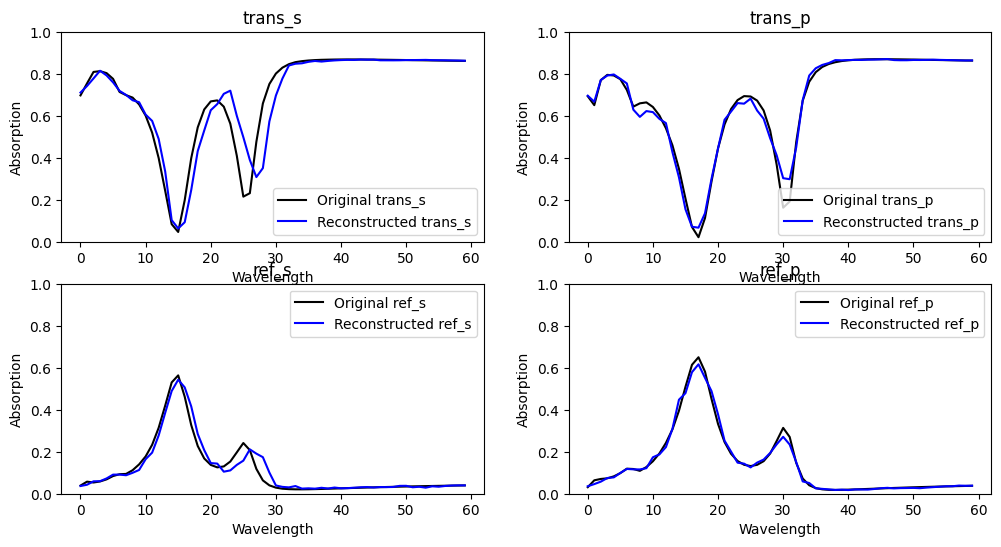

Current Index: 89001


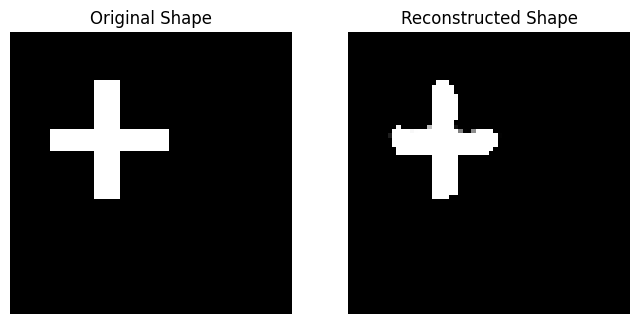

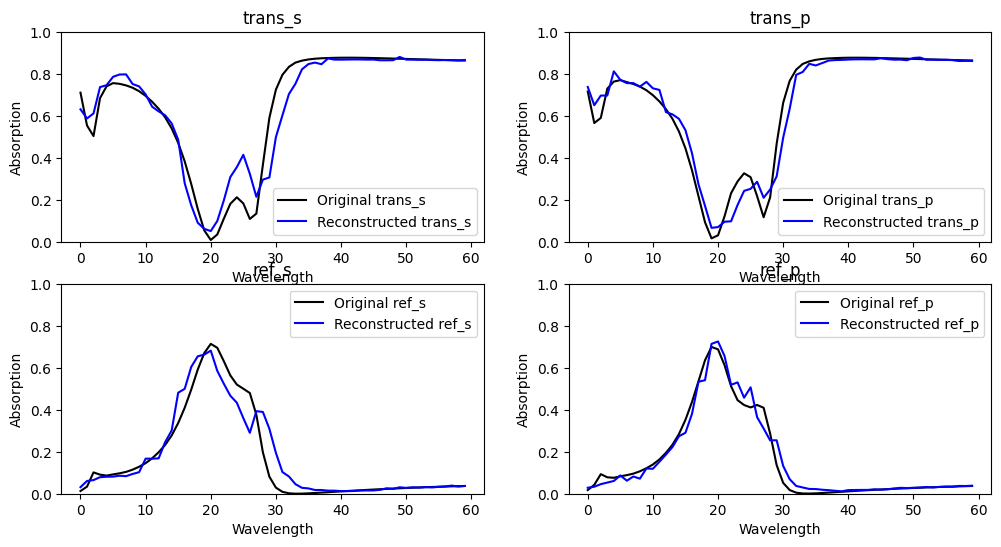

Current Index: 89002


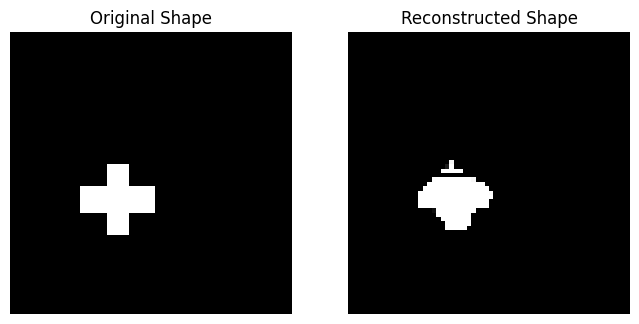

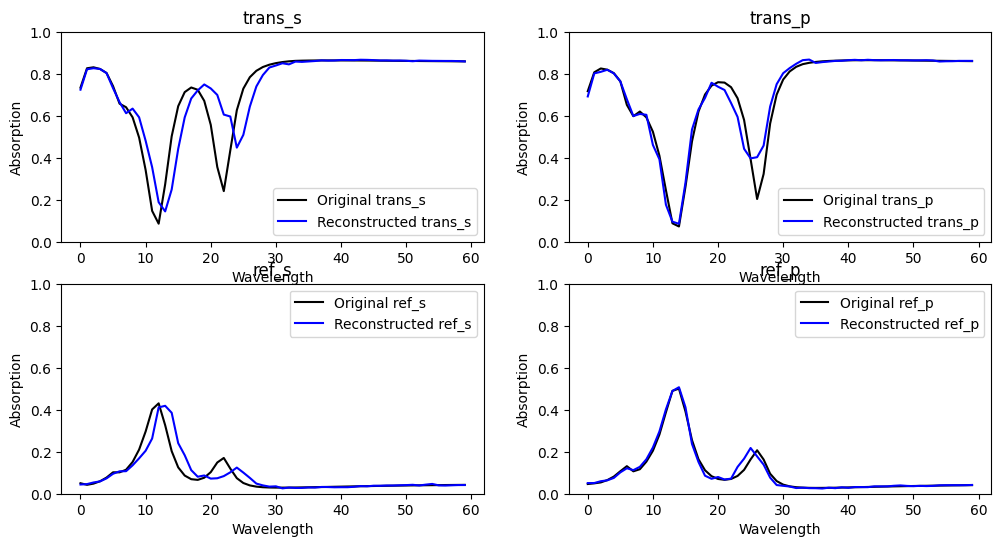

Current Index: 89003


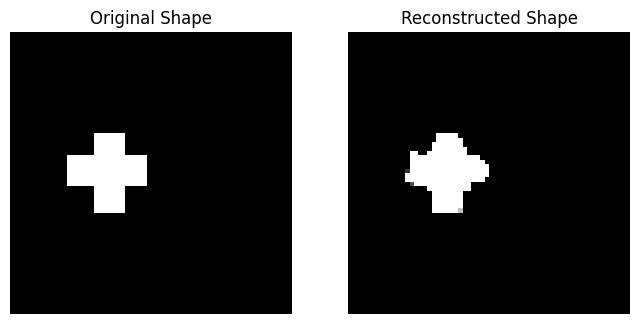

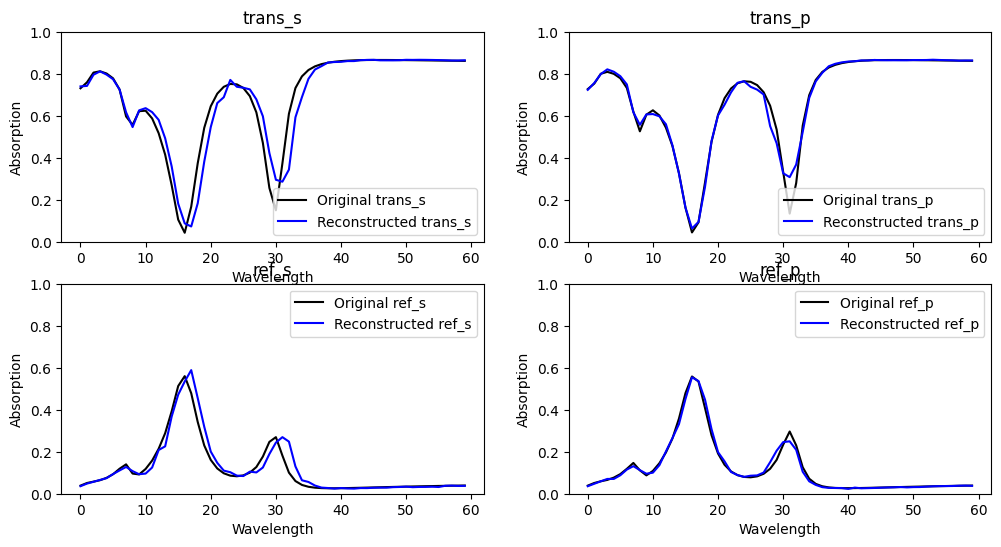

Current Index: 89004


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot shape and spectrum based on index and save spectra to txt files
def plot_shape_and_spectrum_save_txt(index, x_train_shape, x_train_spectra, ccvae_model):
    # Select the data at the specified index
    sample_shape = x_train_shape[index]
    sample_spectrum = x_train_spectra[index]

    # Reshape the data to match the model's input shape
    sample_shape = sample_shape.reshape(1, 64, 64, 1)
    sample_spectrum = sample_spectrum.reshape(1, 60, 4, 1)

    # Encode the shape and spectrum to obtain latent representations
    _, _, z_mean_shape = ccvae_model.shape_encoder.predict(sample_shape)
    _, _, z_mean_spectrum = ccvae_model.spectrum_encoder.predict(sample_spectrum)

    # Decode the latent representations to obtain reconstructed shape and spectrum
    reconstructed_shape = ccvae_model.decoder_shape.predict(z_mean_shape)
    reconstructed_spectrum = ccvae_model.decoder_spectrum.predict(z_mean_spectrum)

    # Plot original and reconstructed shape
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(sample_shape), cmap='gray')
    plt.title("Original Shape")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(reconstructed_shape), cmap='gray')
    plt.title("Reconstructed Shape")
    plt.axis('off')

    plt.show()

    # Plot original and reconstructed spectrum
    categories = ['trans_s', 'trans_p', 'ref_s', 'ref_p']
    plt.figure(figsize=(12, 6))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(sample_spectrum.squeeze()[:, i], label=f'Original {categories[i]}', color='black')
        plt.plot(reconstructed_spectrum.squeeze()[:, i], label=f'Reconstructed {categories[i]}', color='blue')
        plt.xlabel('Wavelength')
        plt.ylabel('Absorption')
        plt.title(categories[i])
        plt.legend()
        plt.ylim(0, 1)
    plt.show()

    # Print the current index number
    print(f"Current Index: {index}")

    # # Save original and reconstructed spectra to txt files
    # np.savetxt(f'original_spectrum_{index}.txt', sample_spectrum.squeeze(), fmt='%f', delimiter='\t')
    # np.savetxt(f'reconstructed_spectrum_{index}.txt', reconstructed_spectrum.squeeze(), fmt='%f', delimiter='\t')

# Specify the starting index you want to visualize
starting_index = 89000

# Iterate through the range of indices (starting from starting_index to starting_index + 100)
for i in range(starting_index, starting_index + 5):
    plot_shape_and_spectrum_save_txt(i, image_data, spectra_data, ccvae)


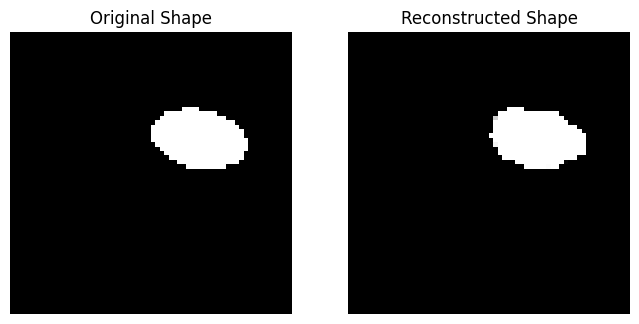

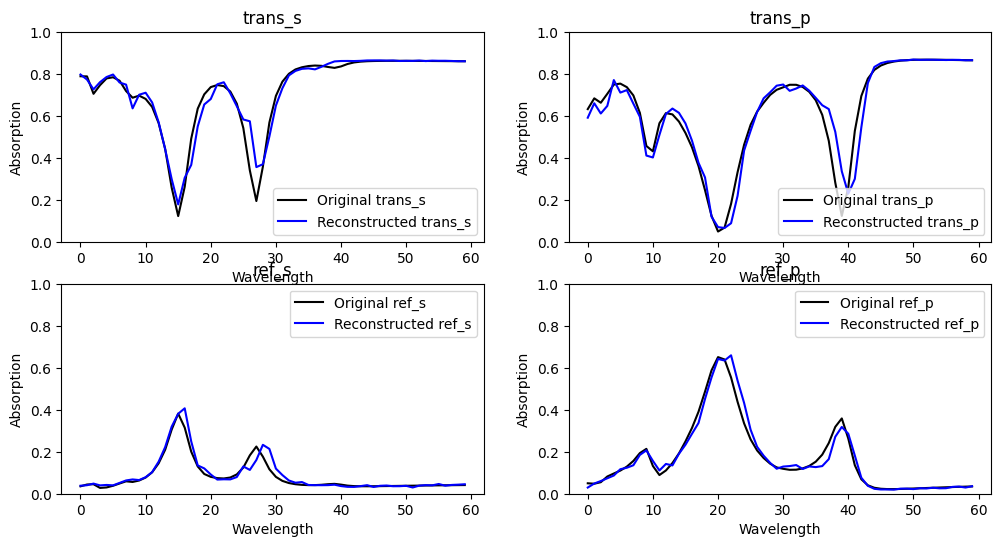

Current Index: 900


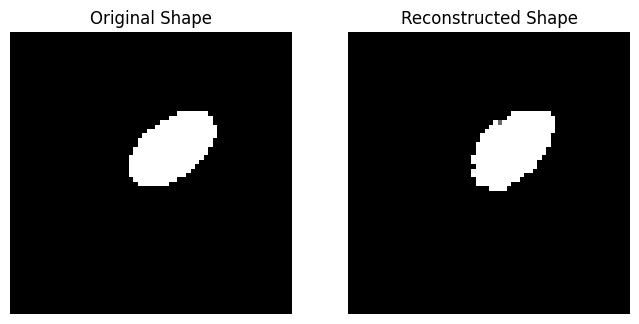

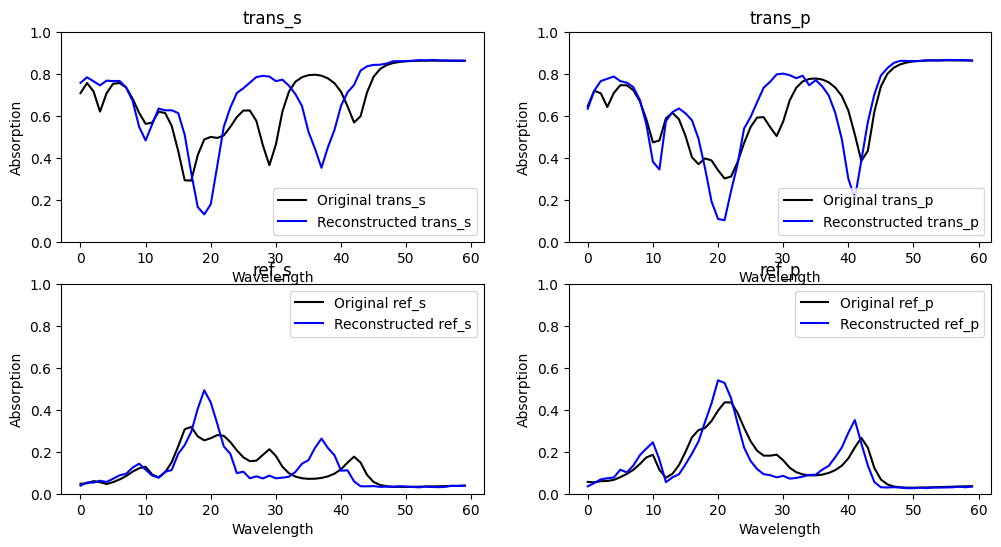

Current Index: 901


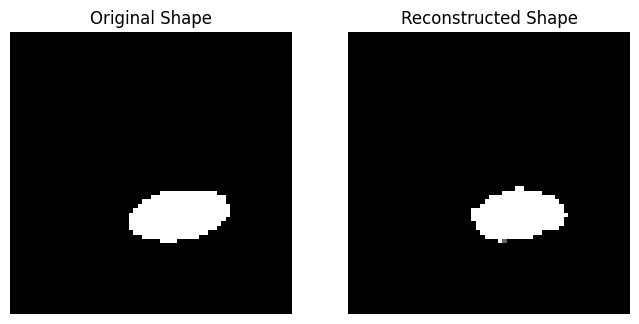

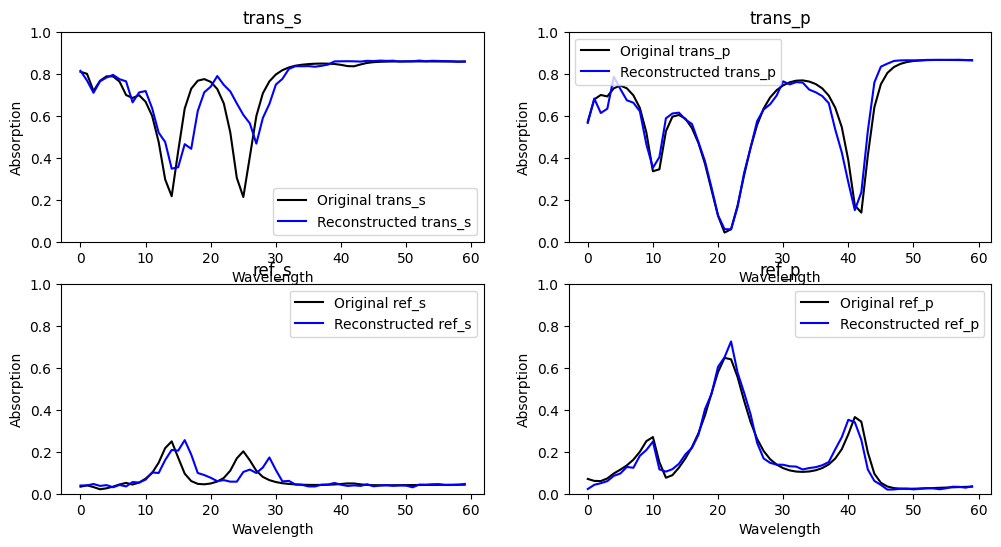

Current Index: 902


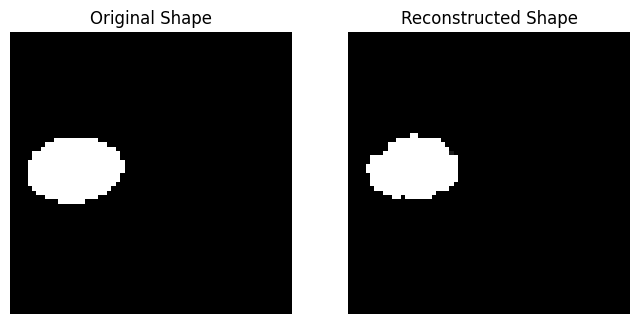

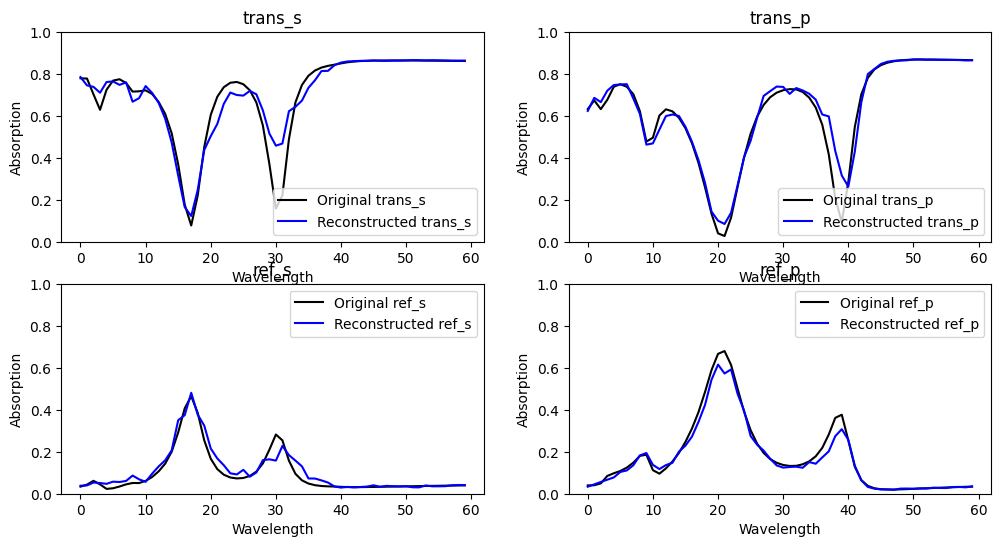

Current Index: 903


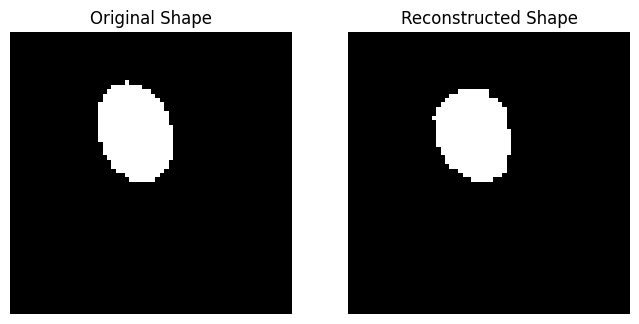

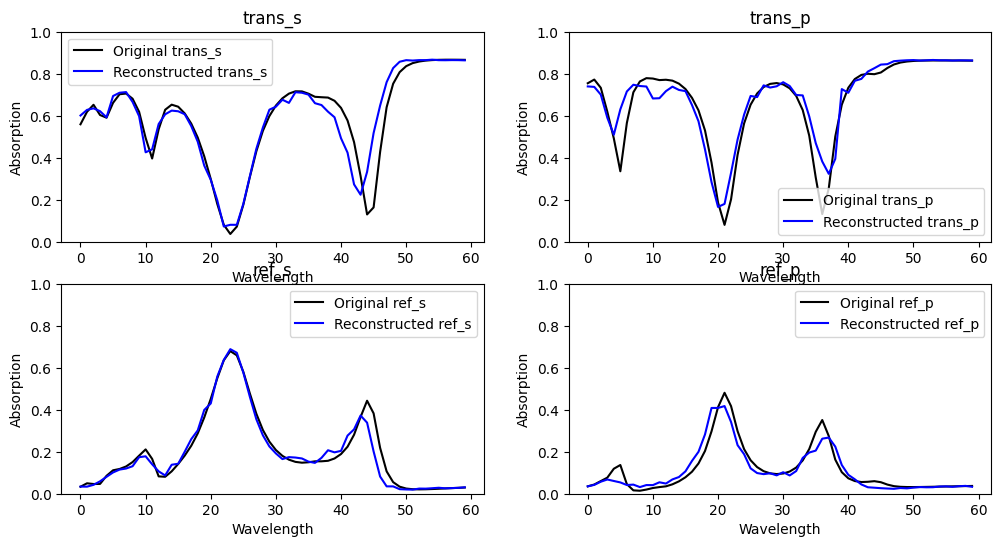

Current Index: 904


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot shape and spectrum based on index and save spectra to txt files
def plot_shape_and_spectrum_save_txt(index, x_train_shape, x_train_spectra, ccvae_model):
    # Select the data at the specified index
    sample_shape = x_train_shape[index]
    sample_spectrum = x_train_spectra[index]

    # Reshape the data to match the model's input shape
    sample_shape = sample_shape.reshape(1, 64, 64, 1)
    sample_spectrum = sample_spectrum.reshape(1, 60, 4, 1)

    # Encode the shape and spectrum to obtain latent representations
    _, _, z_mean_shape = ccvae_model.shape_encoder.predict(sample_shape)
    _, _, z_mean_spectrum = ccvae_model.spectrum_encoder.predict(sample_spectrum)

    # Decode the latent representations to obtain reconstructed shape and spectrum
    reconstructed_shape = ccvae_model.decoder_shape.predict(z_mean_shape)
    reconstructed_spectrum = ccvae_model.decoder_spectrum.predict(z_mean_spectrum)

    # Plot original and reconstructed shape
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(sample_shape), cmap='gray')
    plt.title("Original Shape")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(reconstructed_shape), cmap='gray')
    plt.title("Reconstructed Shape")
    plt.axis('off')

    plt.show()

    # Plot original and reconstructed spectrum
    categories = ['trans_s', 'trans_p', 'ref_s', 'ref_p']
    plt.figure(figsize=(12, 6))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(sample_spectrum.squeeze()[:, i], label=f'Original {categories[i]}', color='black')
        plt.plot(reconstructed_spectrum.squeeze()[:, i], label=f'Reconstructed {categories[i]}', color='blue')
        plt.xlabel('Wavelength')
        plt.ylabel('Absorption')
        plt.title(categories[i])
        plt.legend()
        plt.ylim(0, 1)
    plt.show()

    # Print the current index number
    print(f"Current Index: {index}")

    # # Save original and reconstructed spectra to txt files
    # np.savetxt(f'original_spectrum_{index}.txt', sample_spectrum.squeeze(), fmt='%f', delimiter='\t')
    # np.savetxt(f'reconstructed_spectrum_{index}.txt', reconstructed_spectrum.squeeze(), fmt='%f', delimiter='\t')

# Specify the starting index you want to visualize
starting_index = 900

# Iterate through the range of indices (starting from starting_index to starting_index + 100)
for i in range(starting_index, starting_index + 5):
    plot_shape_and_spectrum_save_txt(i, image_data, spectra_data, ccvae)


# UMAP visualization of the latent space of shape and spectrum

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


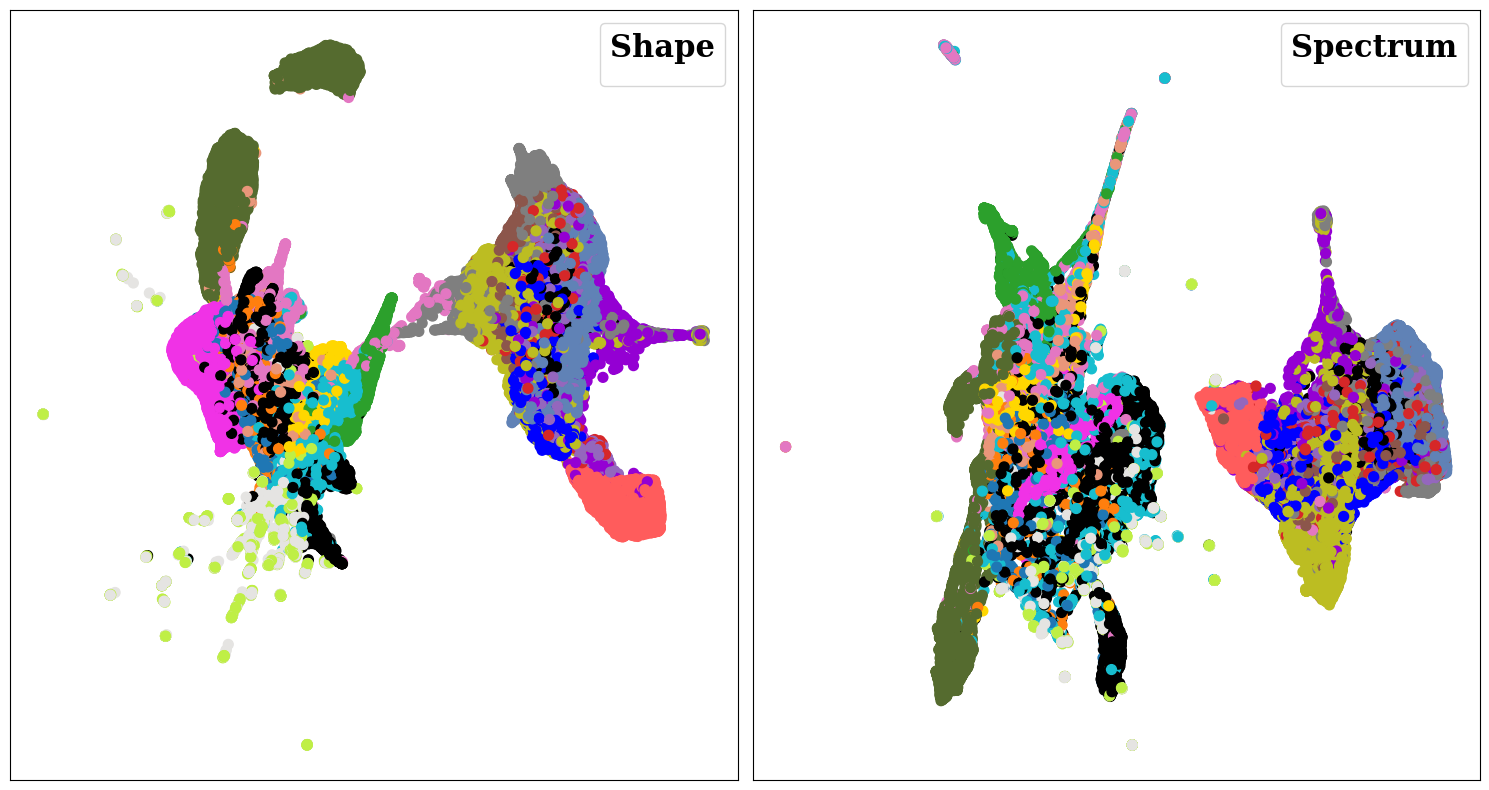

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap

# Load saved UMAP embeddings
umap_shape_embeds = np.load('/home/nano_photonics/linking variational autoencoder complete data/linking_variational_autoencoder/umap_shape_embeds_8.npy')
umap_spectrum_embeds = np.load('/home/nano_photonics/linking variational autoencoder complete data/linking_variational_autoencoder/umap_spectrum_embeds_8.npy')
# Define your custom list of colors (replace with your chosen colors)
my_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000', '#E5E4E2', '#f032e6', '#bfef45', '#0000FF', '#E9967A', '#9400D3', '#FFD700', '#FF5C5C', '#6082B6', '#556B2F']

# # Define unique labels
# unique_labels = np.unique(y_val)

# # Create a custom colormap with 10 distinct colors
# tab10_colors = plt.cm.tab10.colors
# num_colors = len(unique_labels)
# custom_cmap = ListedColormap(tab10_colors[:num_colors])
# Create a ListedColormap from your custom colors
custom_cmap = ListedColormap(my_colors)

# Plot UMAP embeddings in a row
plt.figure(figsize=(15, 8))
# Define a 1x2 grid (removed extra subplots for color bar)
gs = GridSpec(1, 2, width_ratios=[1, 1])

# Set specific axis limits
# x_min, x_max = -12, 19
# y_min, y_max = -11, 16

# # Plot UMAP embeddings in a column
# plt.figure(figsize=(9, 16))  # Adjusted the figure size
# # Define a 2x1 grid for two subplots in a column
# gs = GridSpec(1, 2, height_ratios=[1, 1])

# Plot Shape Latent Space
ax0 = plt.subplot(gs[0])
scatter_shape = ax0.scatter(umap_shape_embeds[:, 0], umap_shape_embeds[:, 1], c=y_val, cmap=custom_cmap, s=50)  # Adjusted marker size
# ax0.set_title('Shape', fontsize=18, fontweight='bold')
ax0.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
legend0 = ax0.legend(title='Shape', fontsize=18)  # Adjusted legend size
legend0.get_title().set_fontweight('bold')  # Set fontweight for legend title
legend0.get_title().set_fontsize(22)  # Adjusted font size for legend text
legend0.get_title().set_fontfamily('serif')  # Set font family for legend title

# Plot Spectrum Latent Space
ax1 = plt.subplot(gs[1])
scatter_spectrum = ax1.scatter(umap_spectrum_embeds[:, 0], umap_spectrum_embeds[:, 1], c=y_val, cmap=custom_cmap, s=50)  # Adjusted marker size
# ax1.set_title('Spectrum', fontsize=18, fontweight='bold')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
legend1 = ax1.legend(title='Spectrum', fontsize=18)  # Adjusted legend size
legend1.get_title().set_fontweight('bold')  # Set fontweight for legend title-
legend1.get_title().set_fontsize(22)  # Adjusted font size for legend text
legend1.get_title().set_fontfamily('serif')  # Set font family for legend title

# Save the figure with DPI value
plt.tight_layout()
# plt.savefig("/home/nano_photonics/linking_variational_autoencoder/VAE_Projection of Latent_Space_12.png", dpi=700)  # Change the file format if needed (e.g., "combined_image.pdf")
plt.show()


# Inverse Design--- Multiple peak gaussian spectra



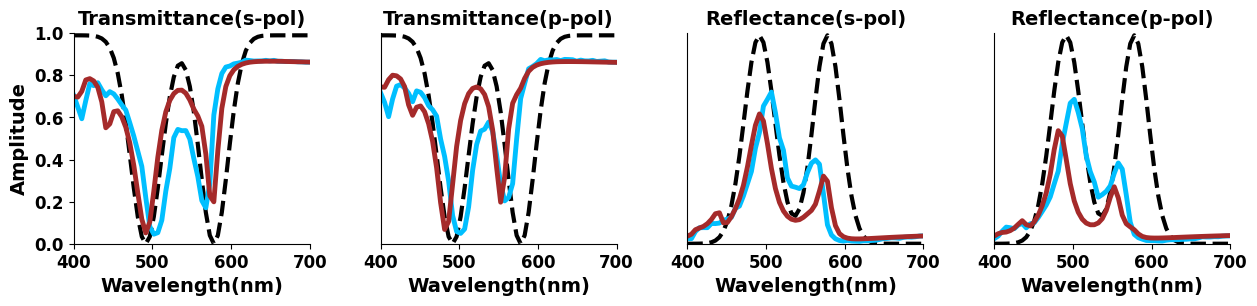

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load matched images, original spectrum, target spectrum, and reconstructed spectra
original_images = np.loadtxt('/home/nano_photonics/rahul2.0/Inverse_design_image_spectra/Inverse_images_all/Step_function/4/Step_function_4.txt')
original_images = np.reshape(original_images, (1, 64, 64, 1))

original_spectrum = np.loadtxt('/home/nano_photonics/rahul2.0/Inverse_design_image_spectra/Inverse_images_all/multiple_gaussians/4/spectrum4.dat')
target_spectrum = np.loadtxt('/home/nano_photonics/rahul2.0/Inverse_design_image_spectra/Target_spectra/multiple_gaussians_4.txt')
reconstructed_spectra = np.loadtxt('/home/nano_photonics/rahul2.0/Inverse_design_image_spectra/Reconstructed_spectra_all/multiple_gaussians_spectra_4.txt')

# Ensure that the reconstructed_spectra has the correct shape (9, 60, 4)
reconstructed_spectra = np.reshape(reconstructed_spectra, (1, 60, 4))

# Load the image using PIL
image_path = '/home/nano_photonics/rahul2.0/inverse_spectra_image_all/step_function/Step_function_17.png'
image = Image.open(image_path)

# Number of categories in the spectrum (trans_s, trans_p, ref_s, ref_p)
categories = 4

# Fixed labels for categories
category_labels = ['Transmittance(s-pol)', 'Transmittance(p-pol)', 'Reflectance(s-pol)', 'Reflectance(p-pol)']

# Color codes for each category in reconstructed spectra
color_codes = ['deepskyblue', 'deepskyblue', 'deepskyblue', 'deepskyblue']

# Color codes for each category in reconstructed spectra
color_codes_1 = ['brown', 'brown', 'brown', 'brown']

# Color codes for target spectra
target_color_codes = ['#6082B6', '#6082B6', '#6082B6', '#6082B6']

# Plot images and spectra in the same row
plt.figure(figsize=(14, 3))  # Adjust the size of the figure as needed

# Define grid structure
grid = plt.GridSpec(1, 6, width_ratios=[0.7, -0.4, 1, 1, 1, 1])

# Plot the loaded image in the first column
ax = plt.subplot(grid[0, 0])
plt.imshow(image, cmap="gray", aspect='equal')  # Set aspect='equal' to maintain the aspect ratio
plt.axis("off")

# Plot spectra in the same row
for category_index in range(categories):
    ax = plt.subplot(grid[0, category_index + 2])

    # Define x_values
    x_values = np.linspace(400, 700, len(target_spectrum))

    # Plot the target spectrum with different color
    target_spec = target_spectrum[:60, category_index]
    plt.plot(x_values, target_spec, label='Target', color='black', ls='--', linewidth=3.0)

    # Plot the average reconstructed spectrum for all spectra
    avg_reconstructed_spectrum = np.mean(reconstructed_spectra[:, :, category_index], axis=0)
    plt.plot(x_values, avg_reconstructed_spectrum, label='Reconstructed', color=color_codes[category_index], ls = '-', linewidth=3.5)
    # Plot the original spectrum
    actual_spectrum = original_spectrum[:60, category_index]
    plt.plot(x_values, actual_spectrum, label='Original', color=color_codes_1[category_index], ls='-', linewidth=3.5)

    plt.xlabel('Wavelength(nm)', fontsize=14, fontweight='bold')

    # Remove the ylabel for columns 3, 4, and 5
    if category_index == 0:
        plt.ylabel('Amplitude', fontsize=14, fontweight='bold')
    else:
        plt.yticks([])

    plt.title(category_labels[category_index], fontsize=14, fontweight='bold')

    plt.xticks(fontweight='bold', fontsize=12)
    plt.yticks(fontweight='bold', fontsize=12)
    plt.ylim(0, 1)
    plt.xlim(400, 700)
    # Remove border from top and right sides
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)


# Adjust spacing between subplots
plt.tight_layout(pad=0.5)

# # Save the plot with sufficient spa
# # # ce for titles
# plt.savefig('/home/nano_photonics/multiple_design/plus_circle_data/inverse_plus_1.png', dpi=500, bbox_inches='tight')
plt.show()


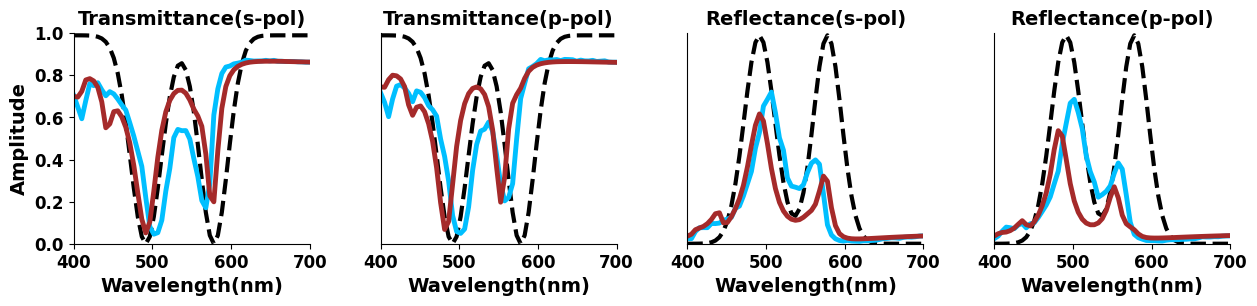

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load matched images, original spectrum, target spectrum, and reconstructed spectra
original_images = np.loadtxt('/home/nano_photonics/rahul2.0/Inverse_design_image_spectra/Inverse_images_all/Step_function/4/Step_function_4.txt')
original_images = np.reshape(original_images, (1, 64, 64, 1))

original_spectrum = np.loadtxt('/home/nano_photonics/rahul2.0/Inverse_design_image_spectra/Inverse_images_all/multiple_gaussians/4/spectrum4.dat')
target_spectrum = np.loadtxt('/home/nano_photonics/rahul2.0/Inverse_design_image_spectra/Target_spectra/multiple_gaussians_4.txt')
reconstructed_spectra = np.loadtxt('/home/nano_photonics/rahul2.0/Inverse_design_image_spectra/Reconstructed_spectra_all/multiple_gaussians_spectra_4.txt')

# Ensure that the reconstructed_spectra has the correct shape (9, 60, 4)
reconstructed_spectra = np.reshape(reconstructed_spectra, (1, 60, 4))

# Load the image using PIL
image_path = '/home/nano_photonics/rahul2.0/inverse_spectra_image_all/step_function/Step_function_17.png'
image = Image.open(image_path)

# Number of categories in the spectrum (trans_s, trans_p, ref_s, ref_p)
categories = 4

# # Fixed labels for categories
# category_labels = ['Transmittance(s-pol)', 'Transmittance(p-pol)', 'Reflectance(s-pol)', 'Reflectance(p-pol)']

# Color codes for each category in reconstructed spectra
color_codes = ['deepskyblue', 'deepskyblue', 'deepskyblue', 'deepskyblue']

# Color codes for each category in reconstructed spectra
color_codes_1 = ['brown', 'brown', 'brown', 'brown']

# Color codes for target spectra
target_color_codes = ['#6082B6', '#6082B6', '#6082B6', '#6082B6']

# Plot images and spectra in the same row
plt.figure(figsize=(14, 3))  # Adjust the size of the figure as needed

# Define grid structure
grid = plt.GridSpec(1, 6, width_ratios=[0.7, -0.4, 1, 1, 1, 1])

# Plot the loaded image in the first column
ax = plt.subplot(grid[0, 0])
plt.imshow(image, cmap="gray", aspect='equal')  # Set aspect='equal' to maintain the aspect ratio
plt.axis("off")

# Plot spectra in the same row
for category_index in range(categories):
    ax = plt.subplot(grid[0, category_index + 2])

    # # Plot the original spectrum
    # actual_spectrum = original_spectrum[:60, category_index]
    # x_values = np.linspace(400, 700, len(actual_spectrum))
    # plt.plot(x_values, actual_spectrum, label='Original', color=color_codes_1[category_index], ls='-', linewidth=3.5)

    # Plot the target spectrum with different color
    target_spec = target_spectrum[:60, category_index]
    plt.plot(x_values, target_spec, label='Target', color='black', ls='--', linewidth=3.0)

    # Plot the average reconstructed spectrum for all spectra
    avg_reconstructed_spectrum = np.mean(reconstructed_spectra[:, :, category_index], axis=0)
    plt.plot(x_values, avg_reconstructed_spectrum, label='Reconstructed', color=color_codes[category_index], ls = '-', linewidth=3.5)
    # Plot the original spectrum
    actual_spectrum = original_spectrum[:60, category_index]
    x_values = np.linspace(400, 700, len(actual_spectrum))
    plt.plot(x_values, actual_spectrum, label='Original', color=color_codes_1[category_index], ls='-', linewidth=3.5)


    plt.xlabel('Wavelength(nm)', fontsize=14, fontweight='bold')

    # Remove the ylabel for columns 3, 4, and 5
    if category_index == 0:
        plt.ylabel('Amplitude', fontsize=14, fontweight='bold')
    else:
        plt.yticks([])

    plt.title(category_labels[category_index], fontsize=14, fontweight='bold')

    plt.xticks(fontweight='bold', fontsize=12)
    plt.yticks(fontweight='bold', fontsize=12)
    plt.ylim(0, 1)
    plt.xlim(400, 700)
    # Remove border from top and right sides
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout(pad=0.5)

# # Save the plot with sufficient spa
# # # ce for titles
# plt.savefig('/home/nano_photonics/multiple_design/plus_circle_data/inverse_plus_1.png', dpi=500, bbox_inches='tight')
plt.show()


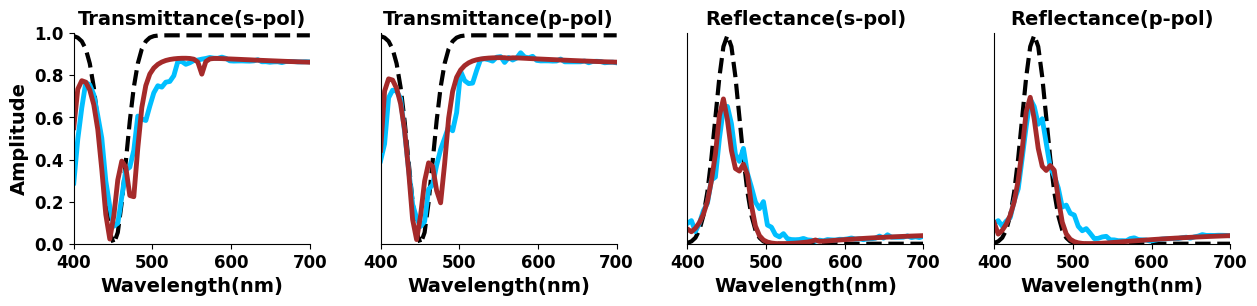

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load matched images, original spectrum, target spectrum, and reconstructed spectra
original_images = np.loadtxt('/home/nano_photonics/rahul2.0/Inverse_design_image_spectra/Inverse_images_all/Step_function/4/Step_function_4.txt')
original_images = np.reshape(original_images, (1, 64, 64, 1))

original_spectrum = np.loadtxt('/home/nano_photonics/linking variational autoencoder complete data/target_sensitivity/circle_inverse/original_spectrum.txt')
target_spectrum = np.loadtxt('/home/nano_photonics/linking variational autoencoder complete data/inverse_design/Target_spectra_1/single_peak_11.txt')
reconstructed_spectra = np.loadtxt('/home/nano_photonics/linking variational autoencoder complete data/target_sensitivity/circle_inverse/reconstructed_spectrum.txt')

# Ensure that the reconstructed_spectra has the correct shape (9, 60, 4)
reconstructed_spectra = np.reshape(reconstructed_spectra, (1, 60, 4))

# Load the image using PIL
image_path = '/home/nano_photonics/rahul2.0/inverse_spectra_image_all/step_function/Step_function_17.png'
image = Image.open(image_path)

# Number of categories in the spectrum (trans_s, trans_p, ref_s, ref_p)
categories = 4

# # Fixed labels for categories
# category_labels = ['Transmittance(s-pol)', 'Transmittance(p-pol)', 'Reflectance(s-pol)', 'Reflectance(p-pol)']

# Color codes for each category in reconstructed spectra
color_codes = ['deepskyblue', 'deepskyblue', 'deepskyblue', 'deepskyblue']

# Color codes for each category in reconstructed spectra
color_codes_1 = ['brown', 'brown', 'brown', 'brown']

# Color codes for target spectra
target_color_codes = ['#6082B6', '#6082B6', '#6082B6', '#6082B6']

# Plot images and spectra in the same row
plt.figure(figsize=(14, 3))  # Adjust the size of the figure as needed

# Define grid structure
grid = plt.GridSpec(1, 6, width_ratios=[0.7, -0.4, 1, 1, 1, 1])

# Plot the loaded image in the first column
ax = plt.subplot(grid[0, 0])
plt.imshow(image, cmap="gray", aspect='equal')  # Set aspect='equal' to maintain the aspect ratio
plt.axis("off")

# Plot spectra in the same row
for category_index in range(categories):
    ax = plt.subplot(grid[0, category_index + 2])

    # # Plot the original spectrum
    # actual_spectrum = original_spectrum[:60, category_index]
    # x_values = np.linspace(400, 700, len(actual_spectrum))
    # plt.plot(x_values, actual_spectrum, label='Original', color=color_codes_1[category_index], ls='-', linewidth=3.5)

    # Plot the target spectrum with different color
    target_spec = target_spectrum[:60, category_index]
    plt.plot(x_values, target_spec, label='Target', color='black', ls='--', linewidth=3.0)

    # Plot the average reconstructed spectrum for all spectra
    avg_reconstructed_spectrum = np.mean(reconstructed_spectra[:, :, category_index], axis=0)
    plt.plot(x_values, avg_reconstructed_spectrum, label='Reconstructed', color=color_codes[category_index], ls = '-', linewidth=3.5)
    # Plot the original spectrum
    actual_spectrum = original_spectrum[:60, category_index]
    x_values = np.linspace(400, 700, len(actual_spectrum))
    plt.plot(x_values, actual_spectrum, label='Original', color=color_codes_1[category_index], ls='-', linewidth=3.5)


    plt.xlabel('Wavelength(nm)', fontsize=14, fontweight='bold')

    # Remove the ylabel for columns 3, 4, and 5
    if category_index == 0:
        plt.ylabel('Amplitude', fontsize=14, fontweight='bold')
    else:
        plt.yticks([])

    plt.title(category_labels[category_index], fontsize=14, fontweight='bold')

    plt.xticks(fontweight='bold', fontsize=12)
    plt.yticks(fontweight='bold', fontsize=12)
    plt.ylim(0, 1)
    plt.xlim(400, 700)
    # Remove border from top and right sides
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout(pad=0.5)

# # Save the plot with sufficient spa
# # # ce for titles
# plt.savefig('/home/nano_photonics/multiple_design/plus_circle_data/inverse_plus_1.png', dpi=500, bbox_inches='tight')
plt.show()


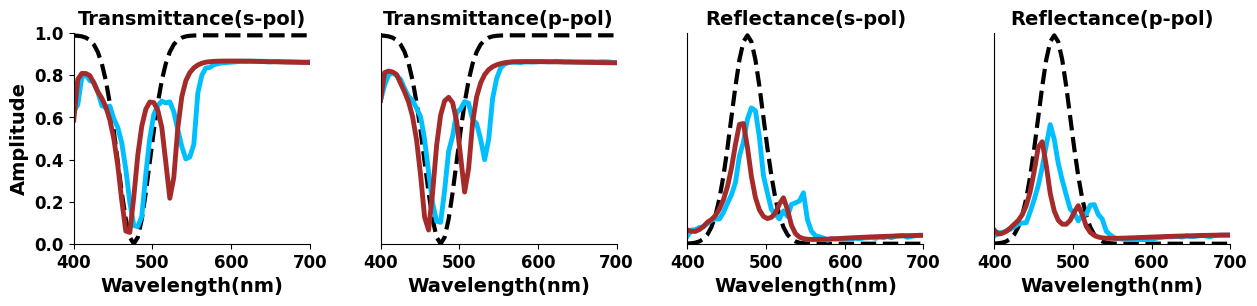

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load matched images, original spectrum, target spectrum, and reconstructed spectra
original_images = np.loadtxt('/home/nano_photonics/rahul2.0/Inverse_design_image_spectra/Inverse_images_all/Step_function/4/Step_function_4.txt')
original_images = np.reshape(original_images, (1, 64, 64, 1))

original_spectrum = np.loadtxt('/home/nano_photonics/linking variational autoencoder complete data/multiple_design/plus_circle_data/original_spectra_plus.txt')
target_spectrum = np.loadtxt('/home/nano_photonics/linking variational autoencoder complete data/multiple_design/plus_circle_data/Target_spectra_12.txt')
reconstructed_spectra = np.loadtxt('/home/nano_photonics/linking variational autoencoder complete data/multiple_design/plus_circle_data/reconstructed_spectra_plus.txt')

# Ensure that the reconstructed_spectra has the correct shape (9, 60, 4)
reconstructed_spectra = np.reshape(reconstructed_spectra, (1, 60, 4))

# Load the image using PIL
image_path = '/home/nano_photonics/rahul2.0/inverse_spectra_image_all/step_function/Step_function_17.png'
image = Image.open(image_path)

# Number of categories in the spectrum (trans_s, trans_p, ref_s, ref_p)
categories = 4

# Fixed labels for categories
category_labels = ['Transmittance(s-pol)', 'Transmittance(p-pol)', 'Reflectance(s-pol)', 'Reflectance(p-pol)']

# Color codes for each category in reconstructed spectra
color_codes = ['deepskyblue', 'deepskyblue', 'deepskyblue', 'deepskyblue']

# Color codes for each category in reconstructed spectra
color_codes_1 = ['brown', 'brown', 'brown', 'brown']

# Plot images and spectra in the same row
plt.figure(figsize=(14, 3))  # Adjust the size of the figure as needed

# Define the wavelength range
wavelength_range = np.linspace(400, 700, 60)  # Assuming 60 data points

# Define grid structure
grid = plt.GridSpec(1, 6, width_ratios=[0.7, -0.4, 1, 1, 1, 1])

# Plot the loaded image in the first column
ax = plt.subplot(grid[0, 0])
plt.imshow(image, cmap="gray", aspect='equal')  # Set aspect='equal' to maintain the aspect ratio
plt.axis("off")

# Plot spectra in the same row
for category_index in range(categories):
    ax = plt.subplot(grid[0, category_index + 2])

    # Plot the target spectrum with different color
    target_spec = target_spectrum[:60, category_index]
    plt.plot(wavelength_range, target_spec, label='Target', color='black', ls='--', linewidth=3.0)

    # Plot the average reconstructed spectrum for all spectra
    avg_reconstructed_spectrum = np.mean(reconstructed_spectra[:, :, category_index], axis=0)
    plt.plot(wavelength_range, avg_reconstructed_spectrum, label='Reconstructed', color=color_codes[category_index], ls='-', linewidth=3.5)

    # Plot the original spectrum
    actual_spectrum = original_spectrum[:60, category_index]
    plt.plot(wavelength_range, actual_spectrum, label='Original', color=color_codes_1[category_index], ls='-', linewidth=3.5)

    plt.xlabel('Wavelength(nm)', fontsize=14, fontweight='bold')

    # Remove the ylabel for columns 3, 4, and 5
    if category_index == 0:
        plt.ylabel('Amplitude', fontsize=14, fontweight='bold')
    else:
        plt.yticks([])

    plt.title(category_labels[category_index], fontsize=14, fontweight='bold')

    plt.xticks(fontweight='bold', fontsize=12)
    plt.yticks(fontweight='bold', fontsize=12)
    plt.ylim(0, 1)
    plt.xlim(400, 700)
    # Remove border from top and right sides
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout(pad=0.5)

# # Save the plot with sufficient space for titles
# plt.savefig('/home/nano_photonics/multiple_design/plus_circle_data/inverse_plus_2.png', dpi=1000, bbox_inches='tight')
plt.show()



# Adding a random noise to the shape latent space and decode the variation between shape and spactrum (sensitivity analysis)

(4096,)


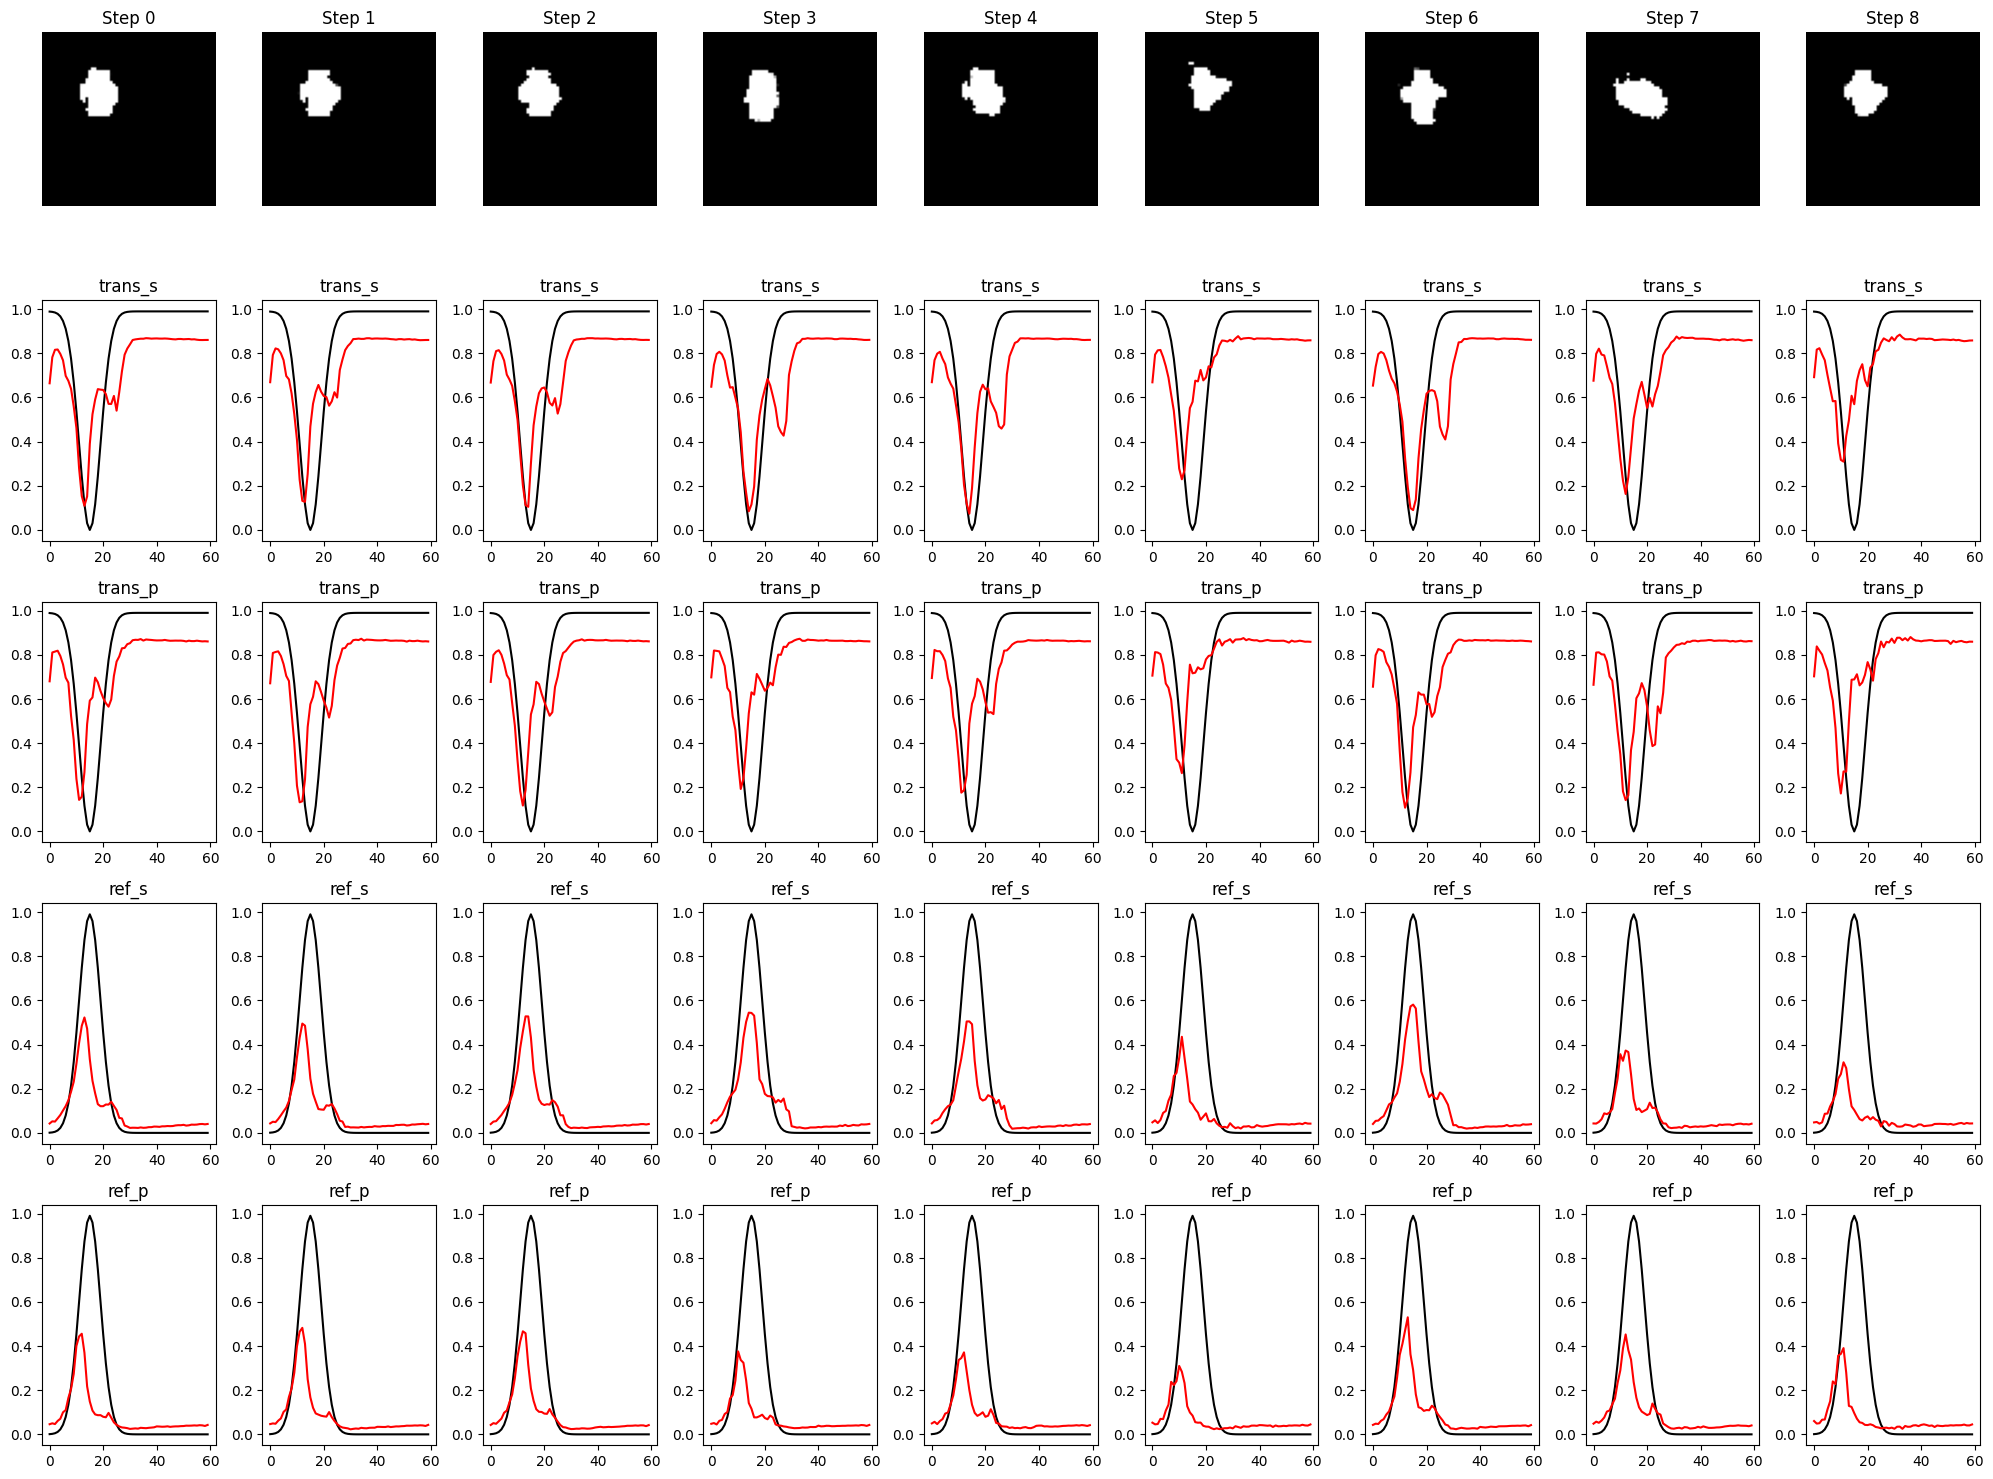

In [ ]:
import matplotlib.pyplot as plt
file_path = '/home/nano_photonics/linking variational autoencoder complete data/target_sensitivity/plus_circle_data/image_plus.txt'
inverse_shape = np.loadtxt(file_path)
print(inverse_shape.shape)
inverse_shape = inverse_shape.reshape(1, 64, 64, 1)
file_path1 = '/home/nano_photonics/linking variational autoencoder complete data/target_sensitivity/plus_circle_data/Target_spectra_12.txt'
spectrum = np.loadtxt(file_path1)
spectrum = spectrum.reshape(1, 60, 4, 1)
# Encode the spectrum to obtain its latent representation
_, _, z_mean_shape = ccvae.shape_encoder.predict(inverse_shape)
latent_dim = 8
# Define the standard deviation for the random noise
initial_noise_std = 0.00
final_noise_std = 0.9
noise_step = 0.11
# Plotting grid
num_steps = int((final_noise_std - initial_noise_std) / noise_step) + 1
plt.figure(figsize=(20, 15))
# Create arrays to store reconstructed images and spectra
reconstructed_images_list = []
reconstructed_spectra_list = []
# Number of categories in the spectrum (trans_s, trans_p, ref_s, ref_p)
categories = 4
# Fixed labels for categories
category_labels = ['trans_s', 'trans_p', 'ref_s', 'ref_p']
for step in range(num_steps):
    # Calculate noise factor for this step
    current_noise_std = initial_noise_std + step * noise_step
    # Add random noise to the latent point within the range (0, 1)
    latent_noise = np.random.normal(0, current_noise_std, size=(1, latent_dim))
    noisy_latent_point = z_mean_shape + latent_noise
    # Decode the noisy latent representation to obtain the reconstructed shape and spectrum
    reconstructed_images_shape = ccvae.decoder_shape.predict(noisy_latent_point)
    reconstructed_spectra_shape = ccvae.decoder_spectrum.predict(noisy_latent_point)
    # Save the reconstructed images and spectra
    reconstructed_images_list.append(reconstructed_images_shape.squeeze())
    reconstructed_spectra_list.append(reconstructed_spectra_shape.squeeze())
    # Reconstructed Image with Noise
    plt.subplot(5, num_steps, step + 1)
    plt.imshow(reconstructed_images_shape.squeeze(), cmap="gray")
    plt.title(f"Step {step}")
    plt.axis("off")
    # Original and Reconstructed Spectrum for each category
    for category_index in range(categories):
        plt.subplot(5, num_steps, (category_index + 1) * num_steps + step + 1)
        spectrum_category = spectrum.squeeze()[:, category_index]
        plt.plot(spectrum_category, color='black')
        reconstructed_spectrum = reconstructed_spectra_shape.squeeze()[:, category_index]
        plt.plot(reconstructed_spectrum,  color='red')
        plt.title(category_labels[category_index])
plt.tight_layout()
plt.show()

# # Save the reconstructed images and spectra to text files
# reconstructed_images_filename = '/home/nano_photonics/target_sensitivity/Circle_plus/Plus1/reconstructed_images_plus.txt'
# reconstructed_spectra_filename = '/home/nano_photonics/target_sensitivity/Circle_plus/Plus1/reconstructed_spectra_plus.txt'

# # Save reconstructed images to a text file
# with open(reconstructed_images_filename, 'w') as file:
#     np.savetxt(file, np.array(reconstructed_images_list).reshape(num_steps, -1), fmt='%d', delimiter='\t')

# # Save reconstructed spectra to a text file
# with open(reconstructed_spectra_filename, 'w') as file:
#     np.savetxt(file, np.array(reconstructed_spectra_list).reshape((num_steps * 60, 4)), fmt='%f', delimiter='\t')


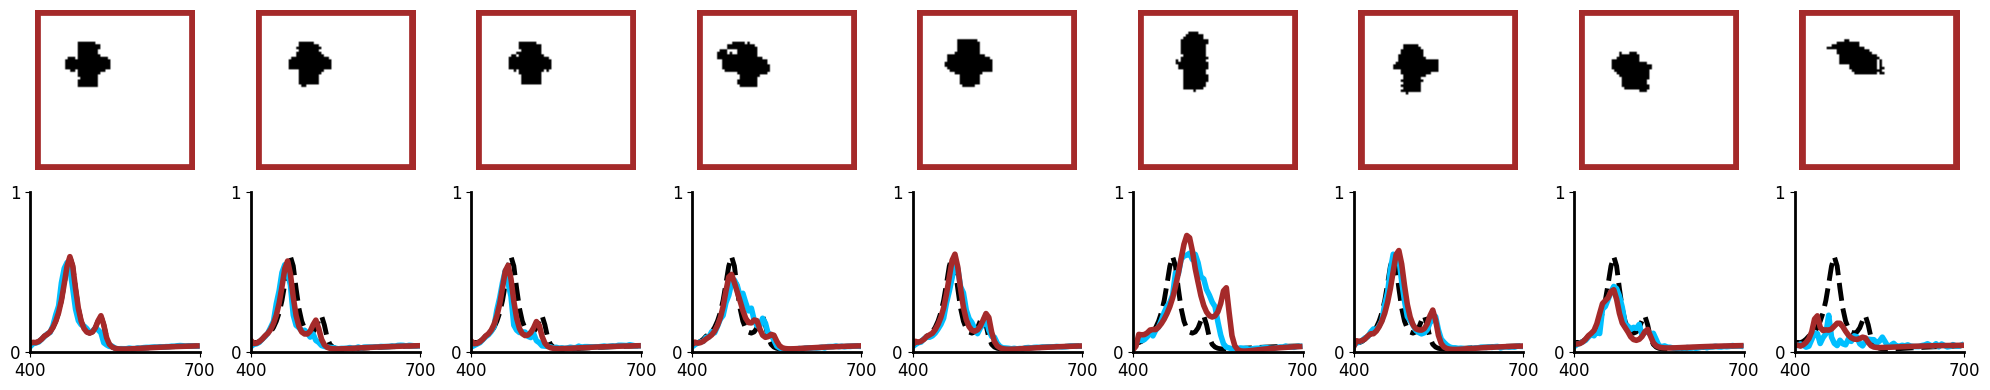

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Load image
image_path_Plus = '/home/nano_photonics/rahul/Plus_sensitivity/reconstructed_images4.txt'
image_path_Plus = np.loadtxt(image_path_Plus)
image_path_Plus = np.reshape(image_path_Plus, (9, 64, 64, 1))

# Load original and reconstructed spectra
original_spectrum_plus = np.loadtxt('/home/nano_photonics/rahul/Plus_sensitivity/spectrum5017.dat')
reconstructed_spectra_plus = np.loadtxt('/home/nano_photonics/rahul/Plus_sensitivity/reconstructed_spectra4.txt')

# Ensure correct shapes for the arrays
original_spectrum_plus = np.reshape(original_spectrum_plus, (9, 60, 4, 1))
reconstructed_spectra_plus = np.reshape(reconstructed_spectra_plus, (9, 60, 4, 1))

# Number of categories in the spectrum (trans_s, trans_p, ref_s, ref_p)
categories = 4

# Fixed labels for categories
category_labels = ['Transmittance(s-pol)', 'Transmittance(p-pol)', 'Reflectance(s-pol)', 'Reflectance(p-pol)']

# Color codes for each category in reconstructed spectra
color_codes = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Define wavelength range
wavelengths = np.arange(400, 700, 5)  # 400 to 700 in steps of 5

# Plotting
fig, axes = plt.subplots(2, len(image_path_Plus), figsize=(20, 4))
# Invert binary values (0 to 1 and 1 to 0)
inverted_image = np.logical_not(image_path_Plus).astype(int)
for idx in range(len(image_path_Plus)):
    # Plot images in the first row
    ax = axes[0, idx]
    ax.imshow(inverted_image[idx], cmap='gray')  # i - 1 because Python uses 0-based indexing
    ax.axis('off')
    # Add rectangular patch to image
    rect = patches.Rectangle((0, 0), 63, 63, linewidth=7.0, edgecolor='brown', facecolor='none')
    ax.add_patch(rect)
    # if idx == 0:
    #     ax.set_title('Base Shape', fontsize=14)  # Title for the first image
    # else:
    #     ax.set_title(f'Derived Shape {idx}', fontsize=14)  # Title for other images

    # Plot target and reconstructed spectra of ref_s in the second row
    for j in range(1):
        ax = axes[1 + j, idx]
        # Calculate the indices corresponding to the wavelength range
        start_idx = int((400 - 400) / 5)
        end_idx = int((705 - 400) / 5) + 1
        ax.plot(wavelengths, original_spectrum_plus[0, start_idx:end_idx, 2 + j], label='Target ref_s', lw=3.5, color='black', linestyle='--')
        ax.plot(wavelengths, reconstructed_spectra_plus[idx, start_idx:end_idx, 2 + j], label='Reconstructed ref_s', lw=4, color='deepskyblue')
        ax.plot(wavelengths, original_spectrum_plus[idx, start_idx:end_idx, 2 + j], label='Target ref_s', lw=4, color='brown')
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.set_xlim(400, 700)  # Adjust the x-axis limits here
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_xticks(np.arange(400, 701, 300), fontsize=13, fontname='Times New Roman')  # Set x-axis ticks with a step size of 100
        ax.set_yticks(np.arange(0, 1.1, 1), fontsize=13, fontname='Times New Roman')  # Set y-axis ticks with a step size of 0.2

# Set y-axis limit
for ax_row in axes[1:]:
    for ax in ax_row:
        ax.set_ylim(0, 1)
        # ax.set_ylabel('Reflectance(s-pol)', fontsize=13, fontname='Times New Roman')
        # ax.set_xlabel('Wavelength(nm)', fontsize=13, fontname='Times New Roman')

# Remove border from top and right sides
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()
# plt.savefig('/home/nano_photonics/target_sensitivity/Circle_plus/again_change_image/reconstructed_images_circle_final.png', dpi=650)
plt.show()


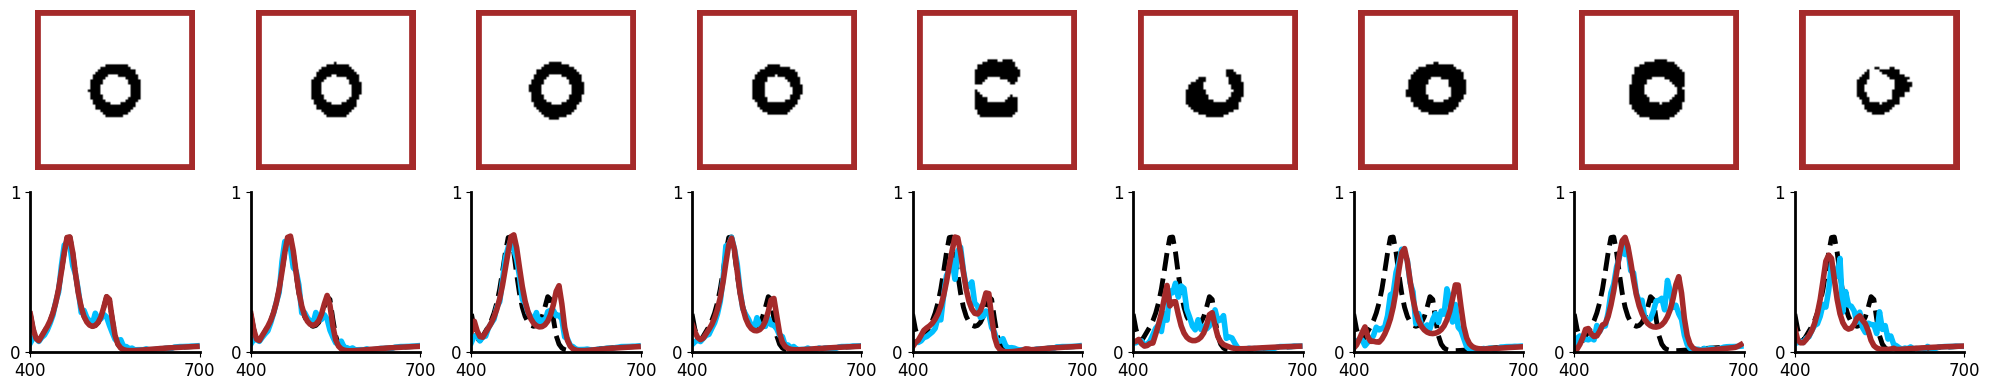

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Load image
image_path_Plus = '/home/nano_photonics/rahul/Circle_sensitivity/reconstructed_images_circle1.txt'
image_path_Plus = np.loadtxt(image_path_Plus)
image_path_Plus = np.reshape(image_path_Plus, (9, 64, 64, 1))

# Load original and reconstructed spectra
original_spectrum_plus = np.loadtxt('/home/nano_photonics/rahul/Circle_sensitivity/spectrum5017.dat')
reconstructed_spectra_plus = np.loadtxt('/home/nano_photonics/rahul/Circle_sensitivity/reconstructed_spectra_circle1.txt')

# Ensure correct shapes for the arrays
original_spectrum_plus = np.reshape(original_spectrum_plus, (9, 60, 4, 1))
reconstructed_spectra_plus = np.reshape(reconstructed_spectra_plus, (9, 60, 4, 1))

# Number of categories in the spectrum (trans_s, trans_p, ref_s, ref_p)
categories = 4

# Fixed labels for categories
category_labels = ['Transmittance(s-pol)', 'Transmittance(p-pol)', 'Reflectance(s-pol)', 'Reflectance(p-pol)']

# Color codes for each category in reconstructed spectra
color_codes = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Define wavelength range
wavelengths = np.arange(400, 700, 5)  # 400 to 700 in steps of 5

# Plotting
fig, axes = plt.subplots(2, len(image_path_Plus), figsize=(20, 4))
# Invert binary values (0 to 1 and 1 to 0)
inverted_image = np.logical_not(image_path_Plus).astype(int)
for idx in range(len(image_path_Plus)):
    # Plot images in the first row
    ax = axes[0, idx]
    ax.imshow(inverted_image[idx], cmap='gray')  # i - 1 because Python uses 0-based indexing
    ax.axis('off')
    # Add rectangular patch to image
    rect = patches.Rectangle((0, 0), 63, 63, linewidth=7.0, edgecolor='brown', facecolor='none')
    ax.add_patch(rect)
    # if idx == 0:
    #     ax.set_title('Base Shape', fontsize=14)  # Title for the first image
    # else:
    #     ax.set_title(f'Derived Shape {idx}', fontsize=14)  # Title for other images

    # Plot target and reconstructed spectra of ref_s in the second row
    for j in range(1):
        ax = axes[1 + j, idx]
        # Calculate the indices corresponding to the wavelength range
        start_idx = int((400 - 400) / 5)
        end_idx = int((705 - 400) / 5) + 1
        ax.plot(wavelengths, original_spectrum_plus[0, start_idx:end_idx, 2 + j], label='Target ref_s', lw=3.5, color='black', linestyle='--')
        ax.plot(wavelengths, reconstructed_spectra_plus[idx, start_idx:end_idx, 2 + j], label='Reconstructed ref_s', lw=4, color='deepskyblue')
        ax.plot(wavelengths, original_spectrum_plus[idx, start_idx:end_idx, 2 + j], label='Target ref_s', lw=4, color='brown')
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.set_xlim(400, 700)  # Adjust the x-axis limits here
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_xticks(np.arange(400, 701, 300), fontsize=13, fontname='Times New Roman')  # Set x-axis ticks with a step size of 100
        ax.set_yticks(np.arange(0, 1.1, 1), fontsize=13, fontname='Times New Roman')  # Set y-axis ticks with a step size of 0.2

# Set y-axis limit
for ax_row in axes[1:]:
    for ax in ax_row:
        ax.set_ylim(0, 1)
        # ax.set_ylabel('Reflectance(s-pol)', fontsize=13, fontname='Times New Roman')
        # ax.set_xlabel('Wavelength(nm)', fontsize=13, fontname='Times New Roman')

# Remove border from top and right sides
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()
# plt.savefig('/home/nano_photonics/target_sensitivity/Circle_plus/again_change_image/reconstructed_images_circle_final.png', dpi=650)
plt.show()
